# Setup

In [1]:

%cd /Users/edoardorossi/Documents/GitHub/Last_tesi
PROJECT_PATH = '/Users/edoardorossi/Documents/GitHub/Last_tesi'
CTA30_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

sys.path.insert(0, os.path.abspath('functions'))
sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
#from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
#from tensorflow.keras import initializers
#from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

#from pkl import store_data, load_data
#from functions.compressor import compress
from functions.mapping import ind2sub, sub2ind3d
from sklearn.model_selection import train_test_split

import random
from collections import defaultdict

from math import log

import re
import time

print("Libraries imported")

/Users/edoardorossi/Documents/GitHub/Last_tesi


2023-07-17 21:00:52.718202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


# Data Import

In [3]:
cta30_def_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')  
df_def = pd.read_csv(cta30_def_path)

try:
    df = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df.csv'))
    df_a = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_a.csv'))
    df_rew = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_rew.csv')) 
    
except:
    cta30_18_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
    cta30_19_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
    cta30_20_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
    cta30_21_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
    cta30_22_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')

    df18= pd.read_csv(cta30_18_path)
    df19= pd.read_csv(cta30_19_path)
    df20= pd.read_csv(cta30_20_path)
    df21= pd.read_csv(cta30_21_path)
    df22= pd.read_csv(cta30_22_path)

    df_complete0 = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)
    df_complete = df_complete0[
        (df_complete0['PW_ATT_M_00'] >= 0) &
        (df_complete0['T_AMB_03'] < 1000) &
        (df_complete0['T_AMB_02'] < 1000) &
        (df_complete0['T_AMB_01'] < 1000) &
        (df_complete0['T_R_00'] < 1000) &
        (df_complete0['T_M_00'] < 1000) & 
        (df_complete0['E_CONS_REAT_M_00'] < 80000) &
        (df_complete0['E_CONS_ATT_M_00'] < 80000) &
        (df_complete0['E_CONS_REAT_R_00'] < 80000) 
    ]

    #drop le colonne 'F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00' 
    df = df_complete.drop(['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00','ANTIGELO_ALARM_00','COSFI_M_00','COSFI_R_00','E_CONS_ATT_M_00','E_CONS_REAT_M_00','E_CONS_REAT_R_00','LOCREM_CMD_00','LOCREM_ST_00','SERR_OUT_DIAG_00','T_M_DIAG_00','T_R_DIAG_00','T_R_SP_00','T_AMB_DIAG_02','T_AMB_DIAG_01','T_AMB_DIAG_00','VLV_RAF_DIAG_00','VLV_SUR_DIAG_00','FILTER_ALRM_01','FILTER_ALRM_00','FILTER_ALRM_02'], axis=1)
    df.reset_index(drop=True, inplace=True)
    # create df_a with only dropped columns
    df_a = df_complete[['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00']]

    df_a['VLV_RAF_REG_00'] = df_a['VLV_RAF_REG_00']/100
    df_a['VLV_SUR_REG_00'] = df_a['VLV_SUR_REG_00']/100

    df_a['VLV_RAF_REG_00'] = df_a['VLV_RAF_REG_00'].apply(lambda x: 1 if x>=0.5 else 0)
    df_a['VLV_SUR_REG_00'] = df_a['VLV_SUR_REG_00'].apply(lambda x: 1 if x>=0.5 else 0)


    df_a['VLV'] = 0 # colonna inizializzata a 0

    df_a.reset_index(drop=True, inplace=True)
    for i in range(len(df)):
            
        if df_a['VLV_RAF_REG_00'][i] == 0 and df_a['VLV_SUR_REG_00'][i] == 0:
            df_a['VLV'][i] = 0
        elif df_a['VLV_RAF_REG_00'][i] == 0 and df_a['VLV_SUR_REG_00'][i] != 0:
            df_a['VLV'][i] = -1
        elif df_a['VLV_RAF_REG_00'][i] != 0 and df_a['VLV_SUR_REG_00'][i] == 0:
            df_a['VLV'][i] = 1
        
        if i == 1544:
            print(df_a['VLV'][i])
        

    df_a = df_a.drop(['VLV_RAF_REG_00', 'VLV_SUR_REG_00'], axis=1)

    df_rew = df_complete[['T_AMB_00', 'T_AMB_01', 'T_AMB_02', 'T_AMB_03', 'PW_ATT_M_00', 'T_M_SP_00']]
    df_rew.reset_index(drop=True, inplace=True)

    print('df shape: ', df.shape)
    print('df_a shape: ', df_a.shape)
    print('df_rew shape: ', df_rew.shape)

    df.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df.csv'), index=False)
    df_a.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_a.csv'), index=False)
    df_rew.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_rew.csv'), index=False)




1544

## DF Loading

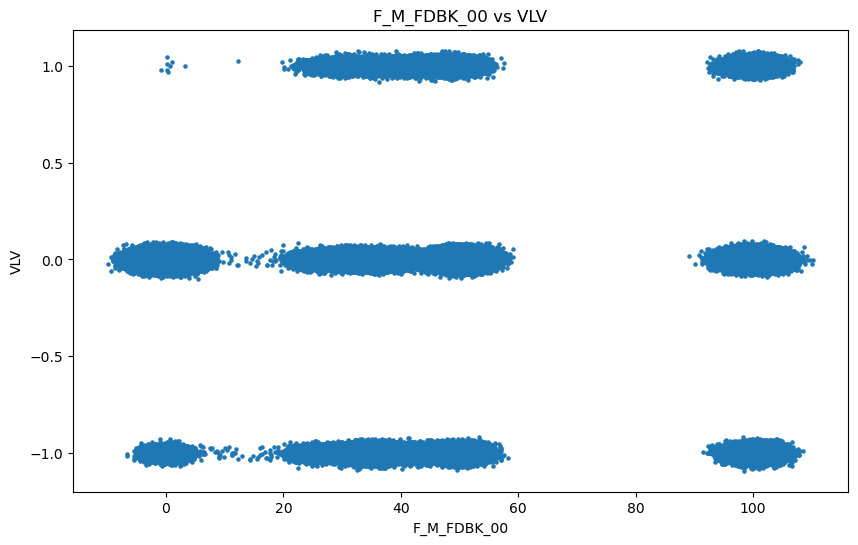

In [4]:
# Generare dei dati casuali con scala comune
x = df_a['F_M_FDBK_00']
y = df_a['VLV']

# Definire la deviazione standard del jitter per l'asse x e l'asse y
x_jitter_std = 2
y_jitter_std = 0.02

# Aggiungere jitter casuale alle coordinate x e y
x_jitter = x + np.random.normal(0, x_jitter_std, size=len(x))
y_jitter = y + np.random.normal(0, y_jitter_std, size=len(y))

# Plot scatter plot con jitter
plt.figure(figsize=(10,6))
plt.scatter(x_jitter, y_jitter, s=5)

# Personalizzazione grafico
plt.xlabel('F_M_FDBK_00')
plt.ylabel('VLV')
plt.title('F_M_FDBK_00 vs VLV')
plt.show()


# Preprocessing

## Normalization

In [5]:
path_scale_norm = os.path.join(PROJECT_PATH, 'MDP_clean_data/scaler_norm.pkl')
try: 
    with open(path_scale_norm, 'rb') as f:
        scale_norm = pickle.load(f)
    df_norm = pd.DataFrame(scale_norm.transform(df), columns=df.columns)
except:
    scale_norm = MinMaxScaler()
    df_norm = pd.DataFrame(scale_norm.fit_transform(df), columns=df.columns)
    with open(path_scale_norm, 'wb') as f:
        pickle.dump(scale_norm, f)

print("The dataset has", df_norm.shape[1], "columns after normalization")

path_pca_norm = os.path.join(PROJECT_PATH, 'MDP_clean_data/pca_norm.pkl')

try:
    with open(path_pca_norm, 'rb') as f:
        pca = pickle.load(f)
    pca_norm = pd.DataFrame(pca.transform(df_norm))
    print("PCA loaded")
except:
    print("Computing PCA")
    pca = PCA(n_components=0.9)
    pca_norm = pd.DataFrame(pca.fit_transform(df_norm))
    with open(path_pca_norm, 'wb') as f:
        pickle.dump(pca, f)
    print("PCA computed")
print("The dataset has", pca_norm.shape[1], "columns after PCA")

df_a_norm = pd.DataFrame(scale_norm.fit_transform(df_a), columns=df_a.columns)


The dataset has 53 columns after normalization
Computing PCA
PCA computed
The dataset has 7 columns after PCA


## Standardization

In [6]:
path_scale_st = os.path.join(PROJECT_PATH, 'MDP_clean_data/scaler_st.pkl')
try: 
    with open(path_scale_st, 'rb') as f:
        scale_st = pickle.load(f)
    df_st= pd.DataFrame(scale_st.transform(df), columns=df.columns)
except:
    scale_st = MinMaxScaler()
    df_st = pd.DataFrame(scale_st.fit_transform(df), columns=df.columns)
    with open(path_scale_st, 'wb') as f:
        pickle.dump(scale_st, f)

path_pca_st = os.path.join(PROJECT_PATH, 'MDP_clean_data/pca_st.pkl')
try:
    with open(path_pca_st, 'rb') as f:
        pca = pickle.load(f)
    pca_st = pd.DataFrame(pca.transform(df_st), columns=df_st.columns)
except:
    pca = PCA(n_components=0.9)
    pca_st = pd.DataFrame(pca.fit_transform(df_st))
    with open(path_pca_st, 'wb') as f:
        pickle.dump(pca, f)
print("The dataset has", pca_st.shape[1], "columns after PCA")

df_a_st = pd.DataFrame(scale_st.fit_transform(df_a), columns=df_a.columns)




The dataset has 7 columns after PCA


# Clustering Analysis

## K-Means

### Stato

In [15]:
X = df_norm

k_min = 72
k_max = 600
step = 55
folder_name = 'fit_norm_no_pca'

n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMeans(n_clusters=(n_clusters), init='k-means++', max_iter=300, n_init=10, random_state=0)
    filepath = os.path.join(PROJECT_PATH, 'MDP_clean_data', 'kmeans_very_clean', folder_name, f'kmeans_{n_clusters}.pkl')
    if os.path.isfile(filepath):
        print(f'kmeans_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X)
        with open(filepath, 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("KMeans with", n_clusters, "clusters computed in", time_elapsed, "seconds")

KMeans with 72 clusters computed in 256.4647490978241 seconds
KMeans with 127 clusters computed in 514.7831737995148 seconds
KMeans with 182 clusters computed in 803.8879020214081 seconds
KMeans with 237 clusters computed in 1051.518059015274 seconds
KMeans with 292 clusters computed in 1517.3950371742249 seconds
KMeans with 347 clusters computed in 1770.5499472618103 seconds
KMeans with 402 clusters computed in 2167.656001806259 seconds
KMeans with 457 clusters computed in 2841.599843263626 seconds


KeyboardInterrupt: 

lista file: 
 ['kmeans_2.pkl', 'kmeans_12.pkl', 'kmeans_22.pkl', 'kmeans_32.pkl', 'kmeans_42.pkl', 'kmeans_72.pkl', 'kmeans_127.pkl', 'kmeans_182.pkl', 'kmeans_237.pkl', 'kmeans_292.pkl', 'kmeans_347.pkl', 'kmeans_402.pkl', 'kmeans_457.pkl']
true x:  [2, 12, 22, 32, 42, 72, 127, 182, 237, 292, 347, 402, 457]
true y:  [6965218.225794205, 1906691.379290887, 1196511.9961017265, 860661.2266237465, 632145.4495481823, 326432.9365636194, 143636.87912406056, 83306.20717805516, 54643.57037905747, 40784.676494174666, 32289.502507051955, 26654.162860693727, 22651.647231755967]


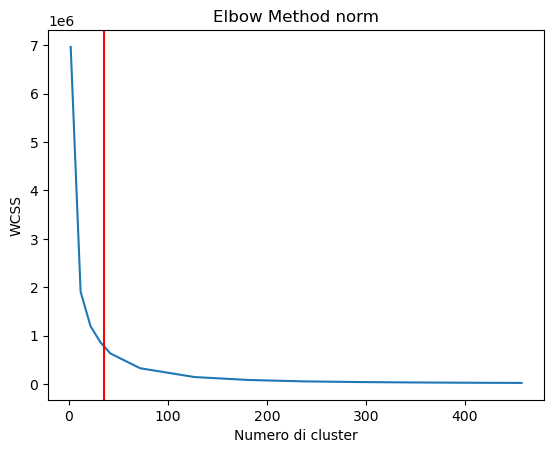

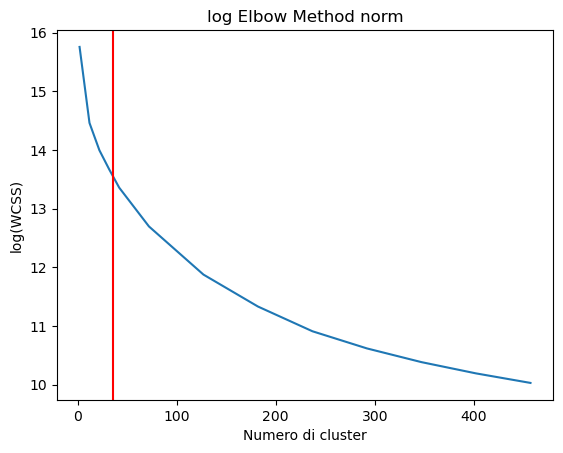

In [16]:
# ELBOW graph

from math import log

folder_name = 'fit_norm_no_pca'
path = os.path.join(PROJECT_PATH, 'MDP_clean_data', 'kmeans_very_clean', folder_name)
file_list = os.listdir(path)

def ordina_file_per_numero(nome_file):
    prefisso = "kmeans_"
    suffisso = ".pkl"
    numero_str = nome_file[len(prefisso):-len(suffisso)]
    numero = int(numero_str)
    return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)

x = []
y = []

print('lista file: \n', file_list_ordinata)

for i in range(len(file_list_ordinata)):

    # carica il file pkl
    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)
    
    #esegui la fit su pca_norm 
    #modello.fit(X)

    #assegna alla variabile x il numero di cluster
    x.append(modello.n_clusters)

    #assegna alla variabile y il valore di wcss 
    y.append(modello.inertia_)

do_it = False
if do_it:
    # itera finché y non è ordinata in modo decrescente
    while y != sorted(y, reverse=True):
        remove_index = []
        for i in range(len(y)-1):
            if y[i] < y[i+1]:
                # salva l'indice i in una variabile e aggiungila alla lista degli indici da rimuovere
                remove_index.append(i)
        for i in remove_index:
            del x[i]
            del y[i]

print('true x: ', x)
print('true y: ', y)
        

elbow = 36
plt.plot(x,y)
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm')
plt.show()

plt.plot(x,[log(i) for i in y])
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('log(WCSS)')
plt.title('log Elbow Method norm')
plt.show()


### Azione

In [17]:
X = df_a_norm
k_min = 2
k_max = 10
step = 1
folder_name = 'fit_norm_a'

n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMeans(n_clusters=(n_clusters), init='k-means++', max_iter=300, n_init=10, random_state=0)
    filepath = os.path.join(PROJECT_PATH, 'MDP_clean_data', 'kmeans_very_clean', folder_name, f'kmeans_{n_clusters}.pkl')
    if os.path.isfile(filepath):
        print(f'kmeans_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X)
        with open(filepath, 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("KMeans with", n_clusters, "clusters computed in", time_elapsed, "seconds")



KMeans with 2 clusters computed in 4.045150995254517 seconds
KMeans with 3 clusters computed in 3.9065651893615723 seconds
KMeans with 4 clusters computed in 5.17247200012207 seconds
KMeans with 5 clusters computed in 5.4965269565582275 seconds
KMeans with 6 clusters computed in 6.5902259349823 seconds
KMeans with 7 clusters computed in 7.375961065292358 seconds
KMeans with 8 clusters computed in 10.125617980957031 seconds


Traceback (most recent call last):
  File "/Users/edoardorossi/opt/anaconda3/envs/tesi_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/edoardorossi/opt/anaconda3/envs/tesi_env/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/edoardorossi/opt/anaconda3/envs/tesi_env/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/Users/edoardorossi/opt/anaconda3/envs/tesi_env/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1030, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
  File "/Users/edoardorossi/opt/anaconda3/envs/tesi_env/lib/python3.10/site-packages/IPython/core/ultratb.py", line 935, in format_ex

Unexpected exception formatting exception. Falling back to standard exception
KMeans with 9 clusters computed in 13.078713178634644 seconds
KMeans with 10 clusters computed in 11.993424892425537 seconds


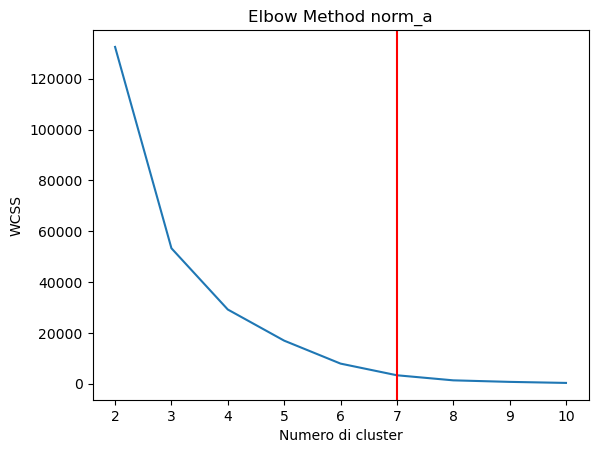

Elbow method finds the best number of clusters at 7 clusters


In [18]:

#for each kmeans_i in folder fit_norm_a compute the elbow method
folder_name = 'fit_norm_a'
path = os.path.join(PROJECT_PATH, 'MDP_clean_data', 'kmeans_very_clean', folder_name)

file_list = os.listdir(path)

# funzione personalizzata per l'ordinamento
def ordina_file_per_numero(nome_file):
    #se il file inizia con kmeans_
    if nome_file.startswith("kmeans_"):
        numero = int(nome_file.split("_")[1].split(".")[0])
        return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)

#crea una lista vuota per i valori di wcss
wcss = []

#carica i pkls e calcola il wcss
for i in range(len(file_list_ordinata)):

    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)

    wcss.append(modello.inertia_)

kmeans_nums = []
for file in file_list:
    match = re.search("kmeans_(\d+)\.pkl", file)
    if match:
        kmeans_num = int(match.group(1))
        kmeans_nums.append(kmeans_num)

#sort the list kmeans_nums
kmeans_nums.sort()


plt.plot(kmeans_nums, wcss)
elbow = 7
#plot a red vertical line at the elbow
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm_a')
plt.show()
print('Elbow method finds the best number of clusters at', elbow, 'clusters')

# Model Generation

## Clustering Generation

In [14]:
X = pca_norm
XX = df_a_norm
df_pos = df_norm
n_clusters = 212
n_actions = 9

try:
    with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/fit_norm/kmeans_{}.pkl'.format(n_clusters), 'rb') as f:
        clustering_model = pickle.load(f)
        print(clustering_model.n_clusters)
except:
    clustering_model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clustering_model.fit(X)
    
    with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/fit_norm/kmeans_{}.pkl'.format(n_clusters), 'wb') as f:
        pickle.dump(clustering_model, f)

try:
    with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/fit_norm_a/kmeans_a_{}.pkl'.format(n_actions), 'rb') as f:
        clustering_model_actions = pickle.load(f)
        print(clustering_model_actions.n_clusters)
except:
    clustering_model_actions = KMeans(n_clusters=n_actions, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clustering_model_actions.fit(XX)
    with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/fit_norm_a/kmeans_a_{}.pkl'.format(n_actions), 'wb') as f:
        pickle.dump(clustering_model_actions, f)

#print centroids of actions
print('centroids of actions: \n', clustering_model_actions.cluster_centers_)
print('X shape: ', X.shape)

df_pos['cluster'] = clustering_model.predict(X)
df_pos['action_clustered'] = clustering_model_actions.predict(XX)
number_of_clusters = len(clustering_model.cluster_centers_)
number_of_actions = len(clustering_model_actions.cluster_centers_)

df_mdp_norm = pd.DataFrame(columns=['S','At'])
df_mdp_norm['S'] = df_pos['cluster']
df_mdp_norm['At'] = df_pos['action_clustered']

save_path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/df_mdp_norm_' + str(n_clusters)+'_a'+ str(n_actions)+'.csv'
df_mdp_norm.to_csv(save_path, index=False)
print(save_path)

212


centroids of actions: 
 [[ 9.96617187e-01  5.00000000e-01]
 [ 2.47551618e-06  5.00000000e-01]
 [ 4.98242381e-01  5.00000000e-01]
 [ 3.29402802e-01  2.58681965e-13]
 [ 4.53014028e-01  1.00000000e+00]
 [ 9.96599958e-01 -9.18709553e-14]
 [ 9.96572427e-01  1.00000000e+00]
 [ 4.91382722e-01 -8.63198402e-14]
 [ 3.04987143e-01  5.00000000e-01]]
X shape:  (2176378, 7)
/Users/edoardorossi/Documents/GitHub/Tesi/MDP_clean_data/kmeans/df_mdp_norm_212_a9.csv


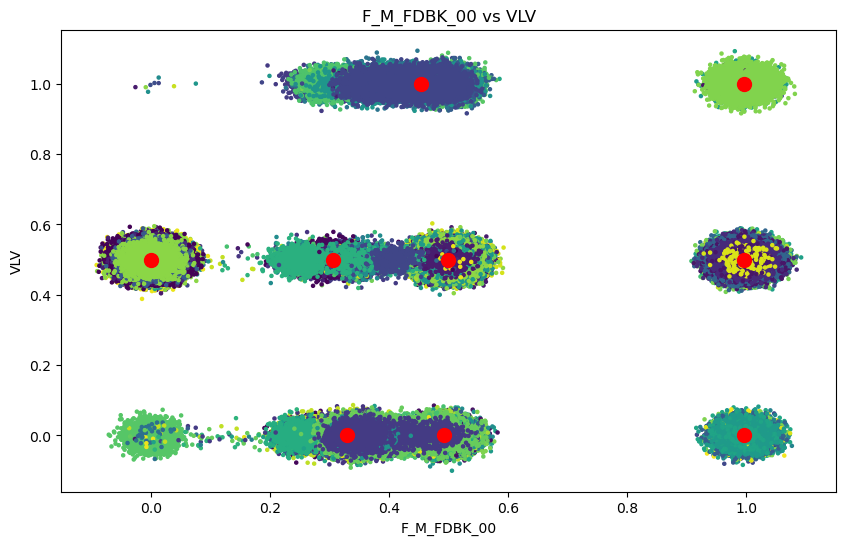

In [16]:
# Generare dei dati casuali con scala comune
x = df_a_norm['F_M_FDBK_00']
y = df_a_norm['VLV']
c = df_pos['cluster']

# Aggiungere jitter casuale alle coordinate x e y
x_jitter = x + np.random.normal(0, 0.02, size=len(x))
y_jitter = y + np.random.normal(0, 0.02, size=len(y))

# Plot scatter plot con jitter
plt.figure(figsize=(10,6))
plt.scatter(x_jitter, y_jitter, s=5, c=c, cmap='viridis')

# Plot centroidi dei cluster
plt.scatter(clustering_model_actions.cluster_centers_[:,0], clustering_model_actions.cluster_centers_[:,1], s=100, c='red', marker='o')

# Personalizzazione grafico
plt.xlabel('F_M_FDBK_00')
plt.ylabel('VLV')
plt.title('F_M_FDBK_00 vs VLV')
plt.show()